In [32]:
import seaborn as sns
from pathlib import Path
import os
from loguru import logger
import math
import jq
import json
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd

2025-04-08 19:43:26.397 | INFO     | __main__:<module>:8 - reading report file ../report/tpch-sf1/duckdb/thread_1.json
2025-04-08 19:43:26.408 | INFO     | __main__:<module>:8 - reading report file ../report/tpch-sf1/duckdb/thread_2.json
2025-04-08 19:43:26.421 | INFO     | __main__:<module>:8 - reading report file ../report/tpch-sf1/duckdb/thread_4.json
2025-04-08 19:43:26.429 | INFO     | __main__:<module>:8 - reading report file ../report/tpch-sf1/duckdb/thread_8.json
2025-04-08 19:43:26.435 | INFO     | __main__:<module>:8 - reading report file ../report/tpch-sf1/duckdb/thread_16.json
2025-04-08 19:43:26.441 | INFO     | __main__:<module>:8 - reading report file ../report/tpch-sf1/duckdb/thread_32.json
2025-04-08 19:43:26.454 | INFO     | __main__:<module>:8 - reading report file ../report/tpch-sf1/duckdb/thread_64.json
2025-04-08 19:43:26.463 | INFO     | __main__:<module>:8 - reading report file ../report/tpch-sf1/duckdb/thread_128.json
2025-04-08 19:43:26.468 | INFO     | __main

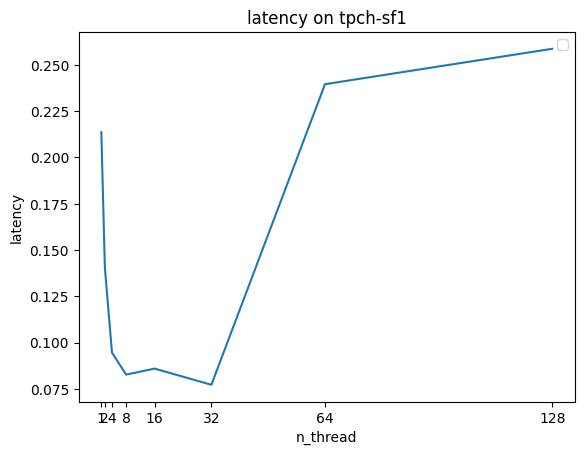

/var/folders/wn/_grd29tn5x9cg9p9_wtwb9nc0000gn/T/ipykernel_21887/3611761402.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


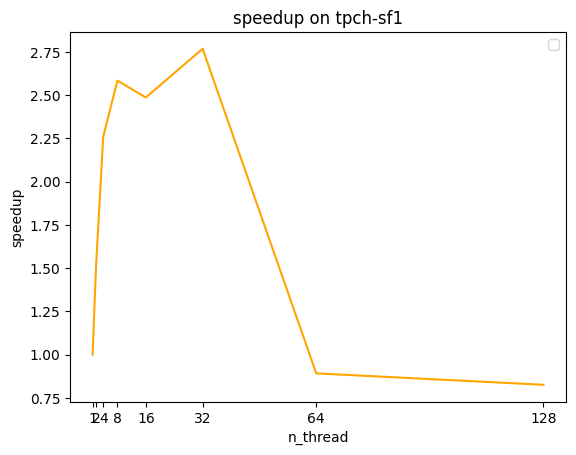

/var/folders/wn/_grd29tn5x9cg9p9_wtwb9nc0000gn/T/ipykernel_21887/3611761402.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


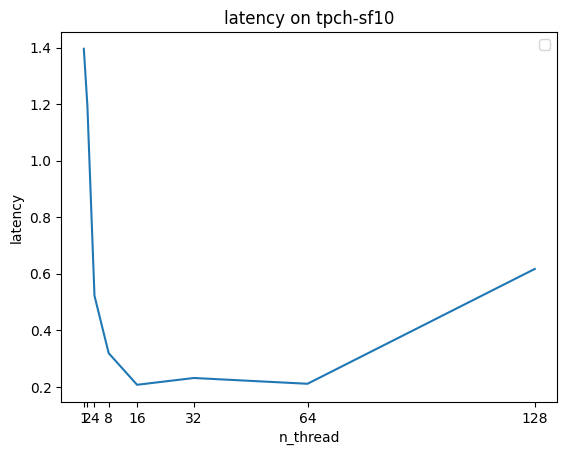

/var/folders/wn/_grd29tn5x9cg9p9_wtwb9nc0000gn/T/ipykernel_21887/3611761402.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


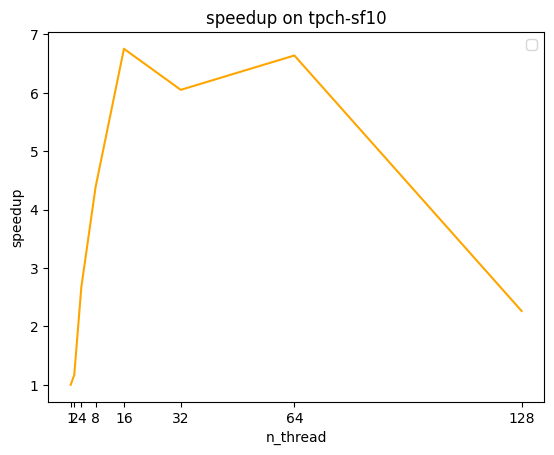

In [49]:
max_thread_cnt = 128
exponent = 0
data_entries = []
for testset in ["tpch-sf1", "tpch-sf10"]:
    for exponent in range(int(math.log2(128)) + 1):
        n_thread = 2 ** exponent
        report_file = f"../report/{testset}/duckdb/thread_{n_thread}.json"
        logger.info(f"reading report file {report_file}")

        with open(report_file) as f:
            json_data = json.load(f)
        cpu_time = jq.compile('.cpu_time').input(json_data).first()
        latency = jq.compile('.latency').input(json_data).first()
        
        data_entries.append({
            "n_thread": n_thread,
            "testset": testset,
            "cpu_time": cpu_time,
            "latency": latency,
        })

df = pl.DataFrame(data_entries)
tick_positions = [2 ** i for i in range(int(math.log2(max_thread_cnt)) + 1)]
for testset in ["tpch-sf1", "tpch-sf10"]:
    
    # 1 > latency plot
    latency_df = df.sql(f"select * from self where testset = '{testset}'")
    # display(latency_df)
    ax = sns.lineplot(data=latency_df, x="n_thread", y="latency")
    ax.set_xticks(tick_positions)
    ax.legend()
    ax.set_title(f"latency on {testset}")
    plt.show()
    
    # 2 > speedup plot
    speedup_df = df.sql(f"""--sql
        select n_thread, testset, first(latency) / latency as speedup
        from self
        where testset = '{testset}'
        order by n_thread
    """)
    # display(speedup_df)
    ax = sns.lineplot(data=speedup_df, x="n_thread", y="speedup", color="orange")
    ax.set_xticks(tick_positions)
    ax.legend()
    ax.set_title(f"speedup on {testset}")
    plt.show()